In [1]:
import os
import sys
from pathlib import Path
sys.path.append(os.path.dirname(os.path.abspath(Path.cwd())))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import src.data_prep.split_data as sd
import src.data_prep.preprocess as pp
import src.data_prep.eda as eda

## Load the Dataset

The [UCI dataset](https://link.springer.com/chapter/10.1007/978-3-642-21257-4_36) consists of 15 different csv files containing the acceleromter data of 15 different subjects. Each subject is asked to perform 7 diffferent activities, and their accelerometer data are recorded by a smartwatch. The data are recorded at **52Hz**. Each activity is given a unique id from 1 to 7, and the labels of them are listed below:
- 1 : workingPC
- 2 : stand
- 3 : stand + walk + stairs
- 4 : walk
- 5 : stairs
- 6 : walk+talk
- 7 : talk

In this notebook, we will be looking at the activity of subject 1 in the UCI dataset. Firstly, we will load the dataset and take a look at the structure of it:

In [2]:

# load the dataset using the load_dataset function, providing the id of the subject (1)
subject_df = pp.load_dataset(subject=1)
# show the first 5 lines of the dataset
subject_df.head()

,timestamp,x,y,z,activity
0,0.0,1502,2215,2153,1
1,1.0,1667,2072,2047,1
2,2.0,1611,1957,1906,1
3,3.0,1601,1939,1831,1
4,4.0,1643,1965,1879,1


Each dataset consists of 5 columns, including: timestamp, x, y, z and activity. There are 7 different activities recorded in this studies, so we want to look at the distribution of each activities (how long each activity is recorded). Next, we plot the dataset as time series and color code each part of the time series according to the indicated activities.

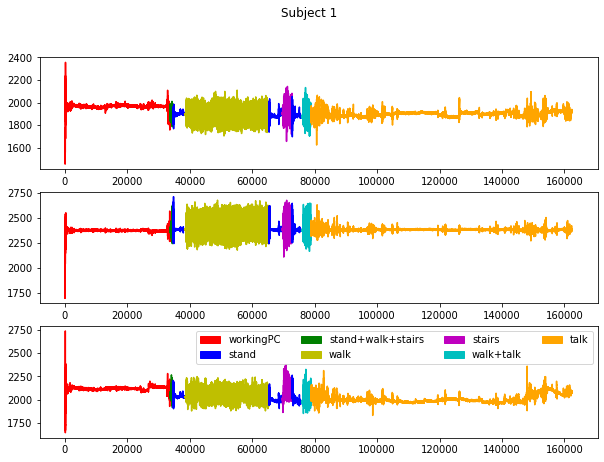

In [3]:
# visualize the entire dataset for subject 1
pp.visualize_data(subject=1).show()

We can see from the chart above, the activities are not equally distribute. We want to take a closer and more accurate look at the duration, in seconds, of each activity recorded.

In [4]:
eda.calculate_activity_duration(subject_df)

,Activity,Duration (in secs)
1,workingPC,647.615385
2,stand,17.846154
3,stand+walk+stairs,214.980769
4,walk,516.538462
5,stairs,61.365385
6,walk+talk,56.096154
7,talk,1610.538462


As we can see from the table above, activity "stand", "stairs" and "walk+talk" have relatively little data, so we might want to remove these activities from our prediction in the future.

Next, we want to look at the accelerometer data of each activities sequence. We will downsample the data to 1/8 of a second, to make the images easier to read:

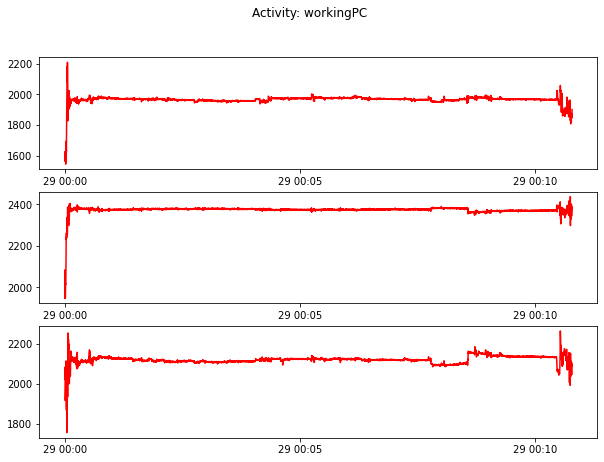

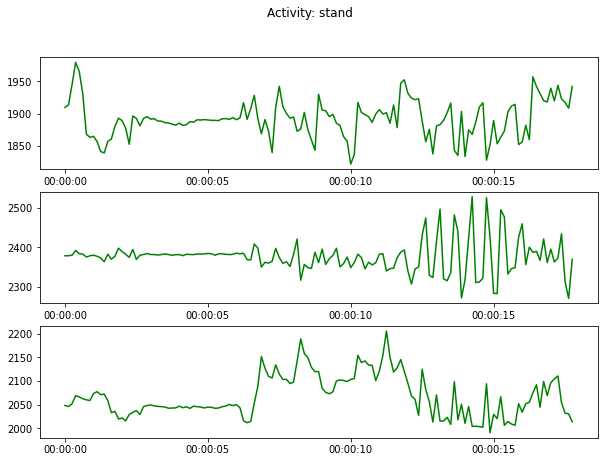

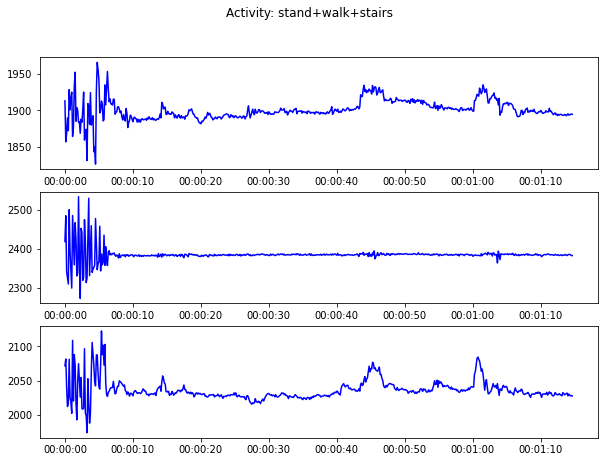

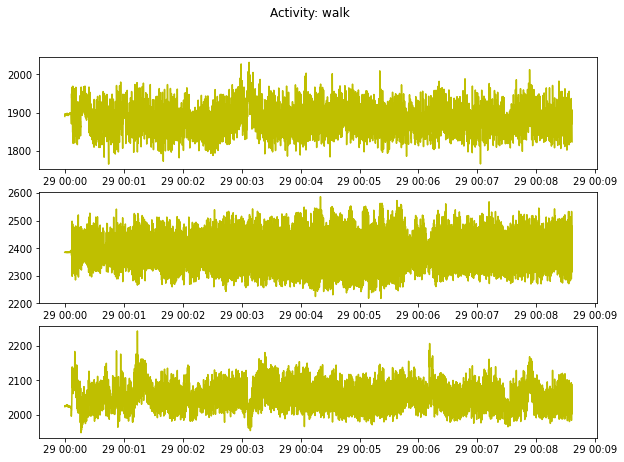

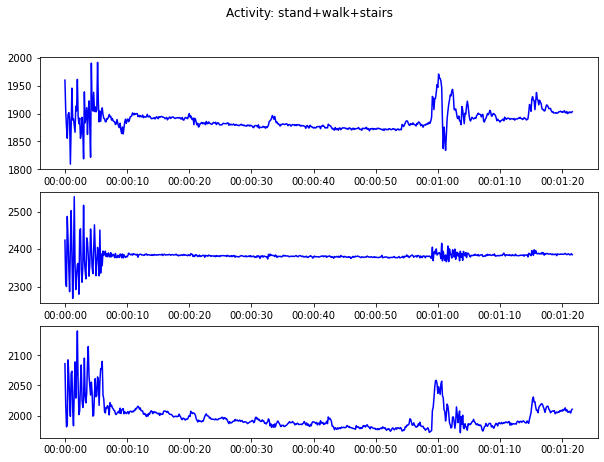

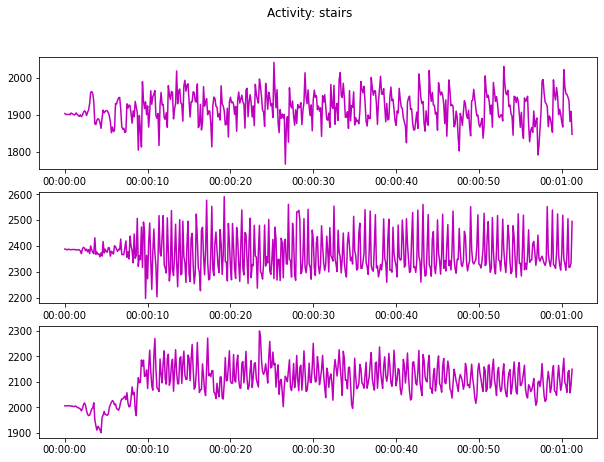

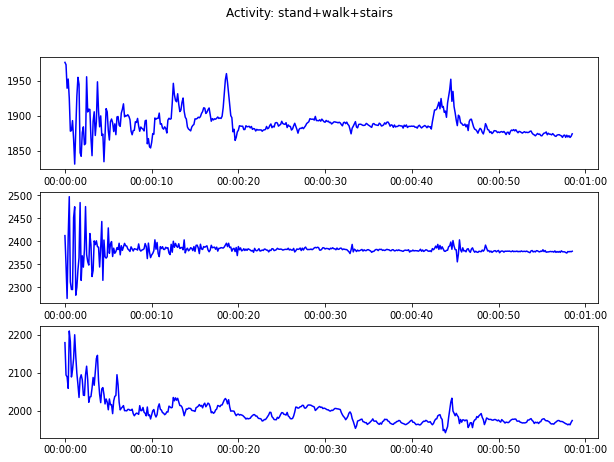

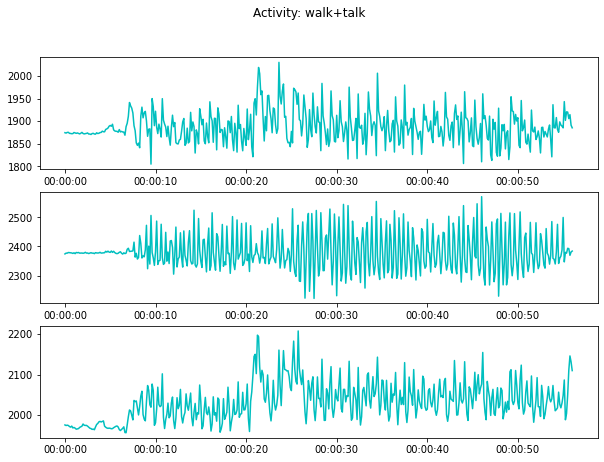

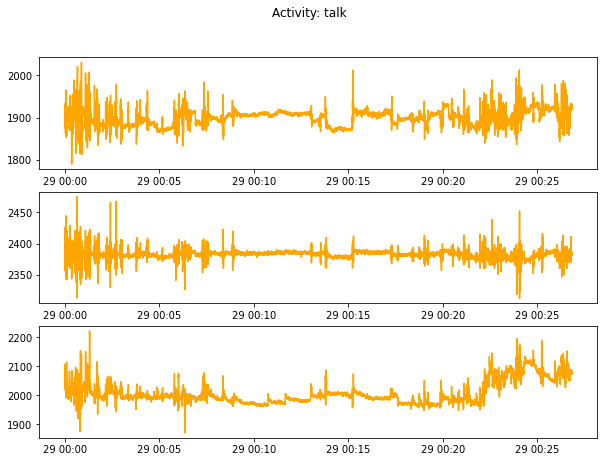

In [5]:
# split the dataset into different sequence, each sequence contains the data of one activity
activity_dfs = pp.split_data_by_activity(subject_df)
for activity in activity_dfs:
    pp.visualize_sequence(activity, sampling_rate="125ms").show()

## Removing Outliers

From the generated images above, we can see that the time series tends to behave weirdly as we move from one activities to another. This can skew our dataset, so we want to delete a portion of the beginning and the ending of some of the activity sequences.

Before we did that, let's print out the sequences of activities that subject 1 take during this studies:

In [6]:
# get the summary of the activities of subject 1
sd.summarize_subject_activities(subject=1)

{0: (1, 'workingPC'),
 1: (2, 'stand'),
 2: (3, 'stand+walk+stairs'),
 3: (4, 'walk'),
 4: (3, 'stand+walk+stairs'),
 5: (5, 'stairs'),
 6: (3, 'stand+walk+stairs'),
 7: (6, 'walk+talk'),
 8: (7, 'talk')}

As we can see, subject 1 performs 9 different activities during the experiment. Activity 3 was repeated twice during the studies, other activities were performed once.

First, we deal with the "workingPC" sequence. Since this is the starting activity, there is a large spike at the beginning and the end of the sequence. We want to delete the first and last 3 seconds of the sequence:

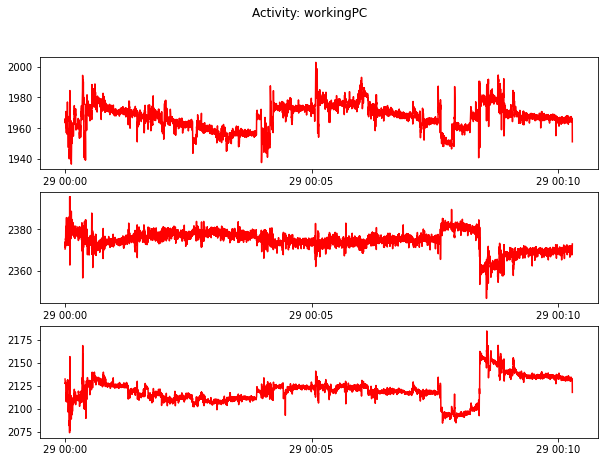

In [7]:
sequence_1 = activity_dfs[0]
# remove the first 5 seconds of the sequence
sequence_1 = eda.removing_outliers(activity_df=sequence_1,
                removed_indices= list(range(0, 520)))
# remove the last 10 seconds of the sequence
sequence_1 = eda.removing_outliers(activity_df=sequence_1,
                removed_indices= list(range(len(sequence_1) - 1040, len(sequence_1) - 1)))
# visualize the sequence after removing outliers
pp.visualize_sequence(sequence_1, sampling_rate="125ms").show()

Next, let's deal with the sequence "stand+walk+stairs". We can see that this sequence always start with strong signal in the beginning, but then die down and stablize. We want to delete the fisrt 10 seconds of all "stand+walk+stairs" sequence:

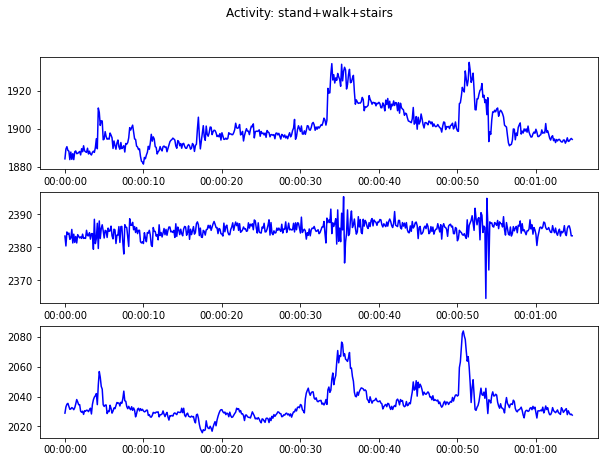

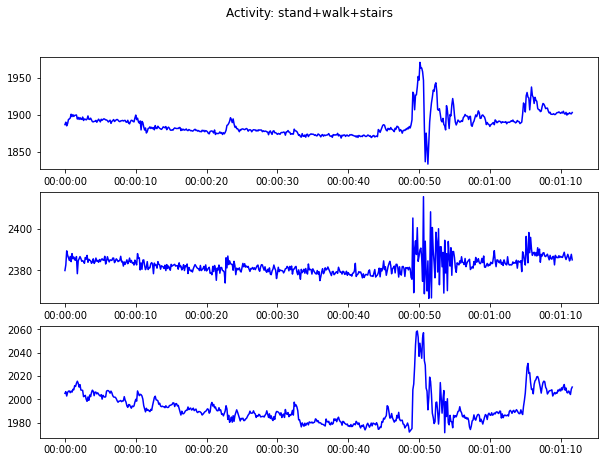

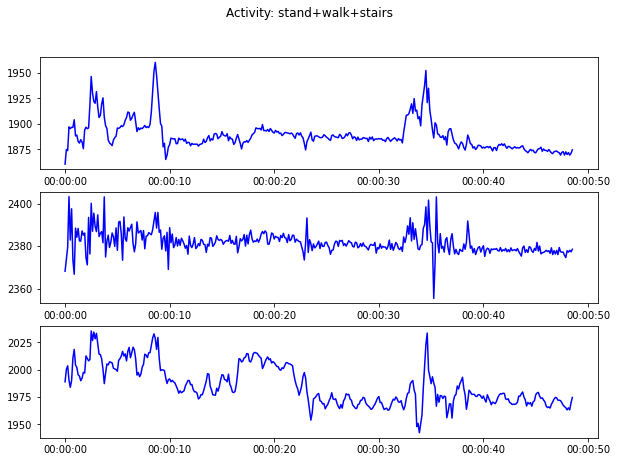

In [8]:
sequence_3 = activity_dfs[2]
sequence_5 = activity_dfs[4]
sequence_7 = activity_dfs[6]
# remove the first 5 seconds of the sequence
sequence_3 = eda.removing_outliers(activity_df=sequence_3,
                removed_indices= list(range(0, 520)))
sequence_5 = eda.removing_outliers(activity_df=sequence_5,
                removed_indices= list(range(0, 520)))
sequence_7 = eda.removing_outliers(activity_df=sequence_7,
                removed_indices= list(range(0, 520)))
# visualize the sequence after removing outliers
pp.visualize_sequence(sequence_3, sampling_rate="125ms").show()
pp.visualize_sequence(sequence_5, sampling_rate="125ms").show()
pp.visualize_sequence(sequence_7, sampling_rate="125ms").show()

Activity "stairs" and "walk+talk" also has minor outliers at the beginning of the sequence, where the time series remains stable at one point and begin to fluctuate wildly as the activity proceed. We will remove the first 5 seconds of each sequence.

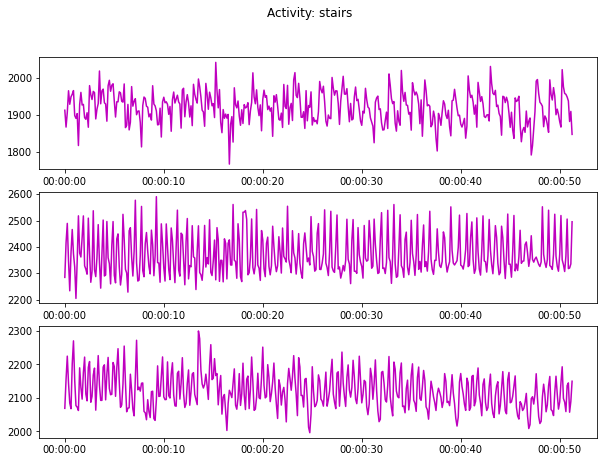

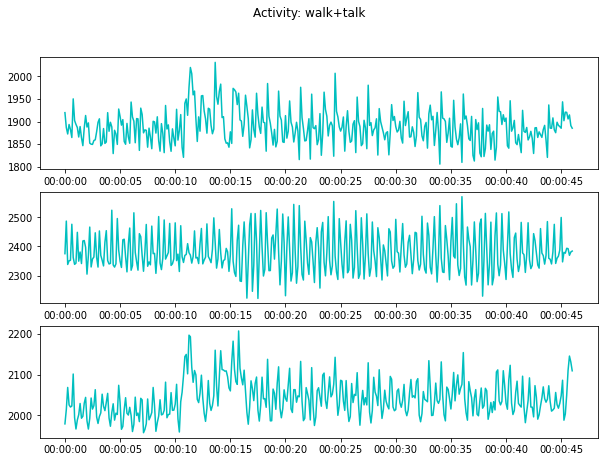

In [9]:
sequence_6 = activity_dfs[5]
sequence_8 = activity_dfs[7]
# remove the first 5 seconds of the sequence
sequence_6 = eda.removing_outliers(activity_df=sequence_6,
                removed_indices= list(range(0, 520)))
sequence_8 = eda.removing_outliers(activity_df=sequence_8,
                removed_indices= list(range(0, 520)))
# visualize the sequence after removing outliers
pp.visualize_sequence(sequence_6, sampling_rate="125ms").show()
pp.visualize_sequence(sequence_8, sampling_rate="125ms").show()

### Basic Statistics of Activity's Sequence
Let plot the distribution of x, y, y using a histogram, to see how these values change for different activity:

<module 'matplotlib.pyplot' from '/opt/homebrew/lib/python3.9/site-packages/matplotlib/pyplot.py'>

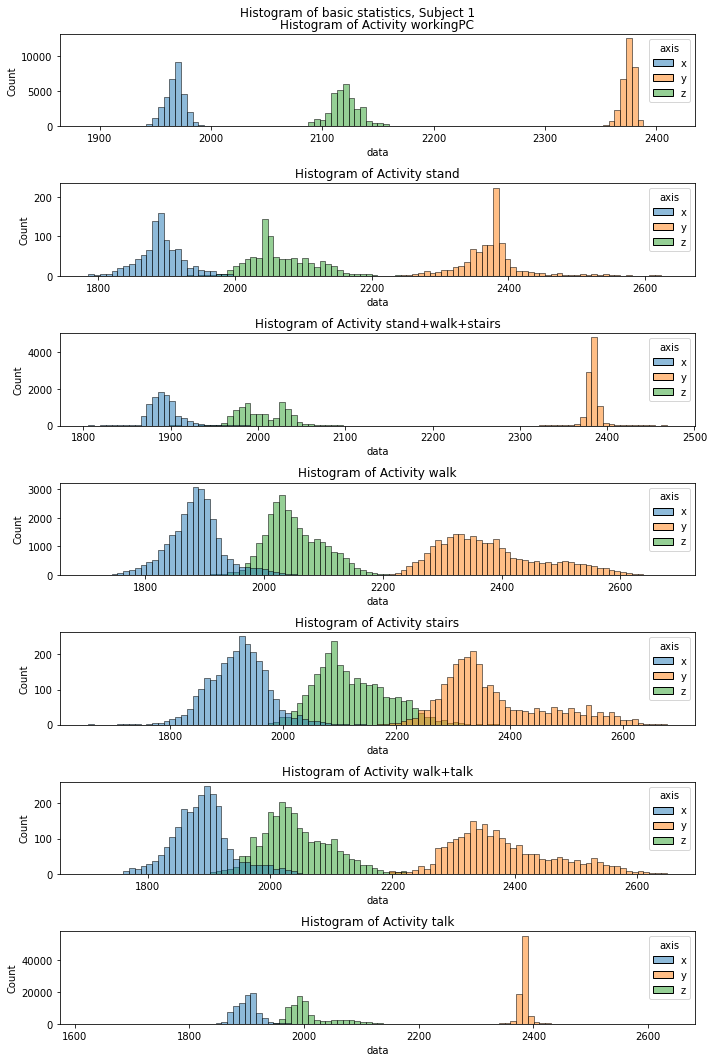

In [10]:
eda.generate_histogram(activity_dfs = activity_dfs)

Overall, we can see that each activity has different distribution. To confirm our observation, let's plot the data using violin plots:

<module 'matplotlib.pyplot' from '/opt/homebrew/lib/python3.9/site-packages/matplotlib/pyplot.py'>

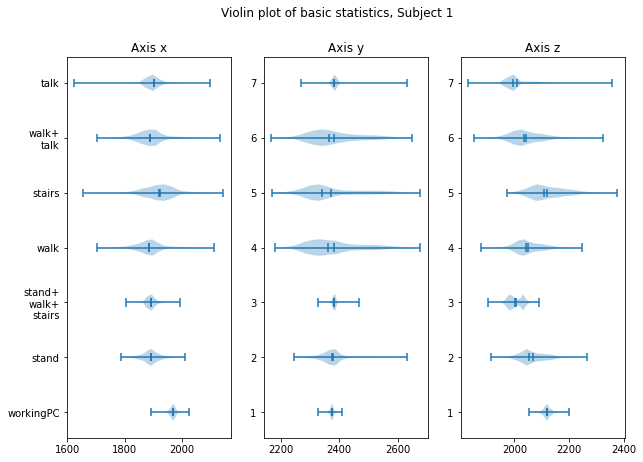

In [11]:
eda.generate_violin_plot(activity_dfs = activity_dfs)

Next, we can generate the tabular report:

In [12]:
merge_dfs = eda.merge_activity_sequence(activity_dfs)
# generate the report for each activity
for activity in merge_dfs:
    print(eda.get_activity_stats(activity))

                 mean        std     min     25%     50%     75%     max
x         1967.496186   8.987091  1890.0  1962.0  1968.0  1973.0  2022.0
y         2374.506025   5.635264  2326.0  2371.0  2375.0  2378.0  2409.0
z         2120.266868  13.596827  2052.0  2112.0  2120.0  2127.0  2199.0
activity     1.000000   0.000000     1.0     1.0     1.0     1.0     1.0
                 mean        std     min      25%     50%     75%     max
x         1891.502155  33.139729  1786.0  1874.00  1890.0  1909.0  2011.0
y         2376.728448  50.493568  2244.0  2353.00  2378.0  2387.0  2631.0
z         2067.889009  48.622886  1915.0  2039.75  2054.0  2100.0  2266.0
activity     2.000000   0.000000     2.0     2.00     2.0     2.0     2.0
                 mean        std     min     25%     50%     75%     max
x         1892.781058  15.712525  1806.0  1882.0  1891.0  1900.0  1991.0
y         2383.329556   6.621305  2327.0  2380.0  2383.0  2387.0  2468.0
z         2005.571473  26.230602  1904.0  1983

## Create Training Dataset

After cleaning and performing EDA on the dataset, we will start creating training dataset so we can fit machine learning model to predict different activities. First, we want to split the sequences into different interval, with 50% overlap. For each interval we produce, we calculate the basic statistics of the interval, and add the activities label at the end. The final result should look like this:

In [13]:
# generate the data per activity
data = []
for activity in activity_dfs:
    data.append(sd.generate_data_per_activity(activity))
# concatenate the data per activity
data = pd.concat(data)
data.head()

,min_x,max_x,mean_x,std_x,range_x,min_y,max_y,mean_y,std_y,range_y,min_z,max_z,mean_z,std_z,range_z,activity
0,1940,1986,1961.088462,7.673593,46,2365,2396,2377.584615,5.437301,31,2086,2143,2115.726923,11.339209,57,1
1,1925,1999,1956.119231,12.374358,74,2340,2409,2379.503846,9.438890,69,2062,2168,2106.846154,18.925973,106,1
2,1919,1999,1953.280769,12.488837,80,2340,2409,2380.869231,9.430001,69,2062,2168,2101.476923,17.485666,106,1
3,1919,1977,1959.707692,10.208972,58,2368,2394,2379.800000,5.014881,26,2077,2138,2107.876923,10.598328,61,1
4,1941,1980,1964.134615,5.983339,39,2369,2390,2378.407692,3.633172,21,2086,2135,2113.100000,6.042130,49,1


After generating the dataset, we can save them in a csv file so we can use it in the next step of our project, fitting and training machine learning model:

In [14]:
# save the data per activity to a csv file
data.to_csv(os.path.dirname(os.path.abspath(Path.cwd())) + "/data/train_data/basic_stats/subject_1.csv", index=False)
# print(os.path.dirname(os.path.abspath(Path.cwd())) + "/data/train_data/basic_stats/subject_1.csv")

Now, if we look at [this folder](/Users/hale/Desktop/adml/data/train_data/basic_stats/subject_1.csv), we can see a file called "subject_1.csv" containing the dataset that we just created.